# Cardano Mainnet Stake Distribution: Implications for Voting

This notebook is best viewed at https://nbviewer.org/.

## Set up

In [1]:
require(bit64)
require(data.table)
require(ggplot2)
require(magrittr)

## Query `cardano-db-sync`

```sql
select
    epoch_no                  as "Epoch"
  , encode(hash_raw, 'hex')   as "Pool"
  , sum(amount)               as "Stake [Lovelace]"
  , sum(amount) / total_stake as "Stake [Fraction]"
  from epoch_stake
  inner join pool_hash
    on epoch_stake.pool_id = pool_hash.id
  inner join (
    select epoch_no, sum(amount) as total_stake
      from epoch_stake
      group by epoch_no
  ) stake_total
    using (epoch_no)
  group by epoch_no, hash_raw, total_stake
;

\copy stake_distribution to 'stake_distribution.csv' csv header
```

In [2]:
stakeDistribution <- fread("http://ipfs.functionally.io/ipfs/QmbnnWaaKTQddiefiEUxruh2w2wa6eFn9FFb7y82wm3ubz")[order(`Epoch`, `Stake [Lovelace]`)][`Stake [Lovelace]` > 0]
stakeDistribution %>% summary

     Epoch           Pool           Stake [Lovelace]         
 Min.   :210.0   Length:820505      Min.   :             16  
 1st Qu.:308.0   Class :character   1st Qu.:     2488192396  
 Median :377.0   Mode  :character   Median :   154548144737  
 Mean   :376.6                      Mean   :  8594972171029  
 3rd Qu.:447.0                      3rd Qu.:  4577810115154  
 Max.   :518.0                      Max.   :486514766981074  
 Stake [Fraction]   
 Min.   :0.000e+00  
 1st Qu.:1.040e-07  
 Median :6.740e-06  
 Mean   :3.766e-04  
 3rd Qu.:1.983e-04  
 Max.   :3.107e-02  

## Plot the stake distribution by epoch

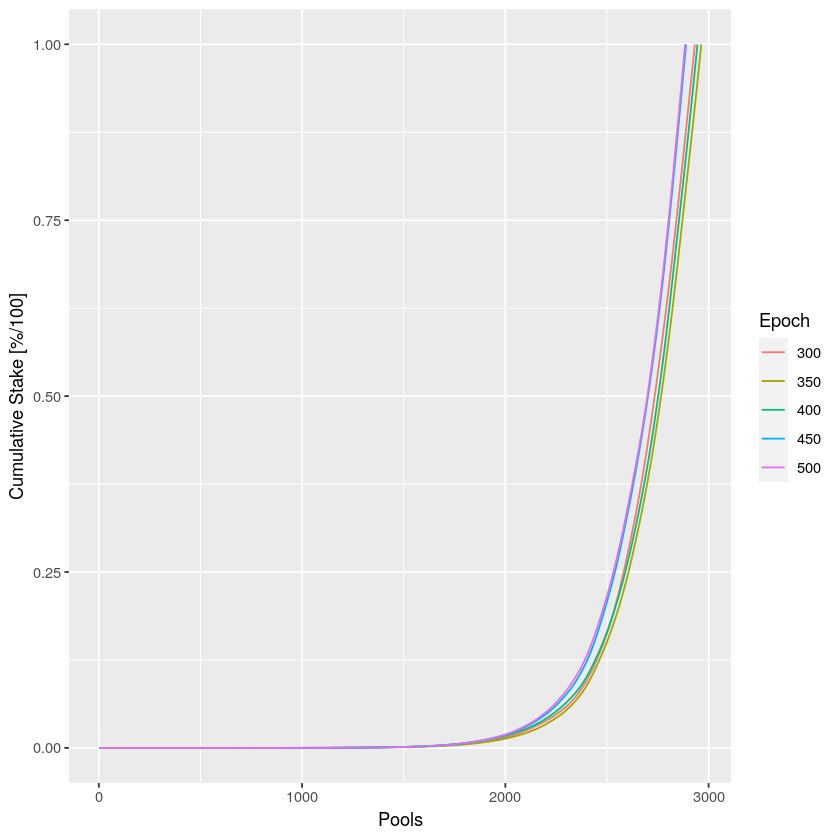

In [3]:
ggplot(
    stakeDistribution[
        `Epoch` %in% c(300,350,400,450,500),
        .(`Pools`=rank(.I), `Cumulative Stake [%/100]`=cumsum(`Stake [Fraction]`)),
        by=.(`Epoch`=factor(`Epoch`))
    ],
    aes(x=`Pools`, y=`Cumulative Stake [%/100]`, color=`Epoch`)
) +
  geom_line()

In [4]:
ggsave("stake_distribution.svg", width=8, height=6, units="in", dpi=200)

In [5]:
ggsave("stake_distribution.png", width=8, height=6, units="in", dpi=200)

## Number of unique nodes in voting committee

Let $p$ be the probability that a unit of stake (i.e., one lovelace in Cardano) will be selected in the voting lottery and let $S$ be the total staked. Let $n$ be the desired mean number of votes in the lottery. Hence $p = n / S$.

A candidate node $i$ with $s_i$ staked to it has a binomially distributed number of votes, with mean $p \cdot s_i$. The probability $v_i = 1 - \left( 1 - p \right)^{s_i}$ that the node has any votes at all.

We want to know how many distinct nodes vote in a given round. If the random variable $\mathbf{V}_i$ is distributed according to the Bernoulli trial with probability $v_i$, then $\mathbf{V} = \sum_i \mathbf{V}_i$ is the committee size. This will differ from the number of votes because some nodes might have multiple votes.

It's feasible to numerically sample $\mathbf{V}$, but simply computing its mean and standard deviation is insightful. The mean is $\mu = \sum_i v_i$ and the variance is $\sigma^2 = \sum_i v_i \cdot \left( 1 - v_i \right)$.

Below we estimate $\mu$ and $\mu \pm 2 \sigma$ for the empirical distribution of stake.

In [6]:
# Statistics for a mean committee size `n` and a stake distribution `stake`.
committee <- function(n, stakes) {
    p <- n / sum(stakes)
    v0 <- (1 - p)^as.numeric(stakes)
    v1 <- 1 - v0
    meanC <- sum(v1)
    sdC <- sum(v0 * v1) %>% sqrt
    list(`μ`=meanC, `μ-2σ`=meanC-2*sdC, `μ+2σ`=meanC+2*sdC)
}

In [7]:
voteplot <- function(n)
    
ggplot(
    melt(
        stakeDistribution[, committee(n, `Stake [Lovelace]`), by=.(`Epoch`)], 
        id.vars=c("Epoch"), 
        measure.vars=c("μ+2σ", "μ", "μ-2σ"),
        variable.name="Statistic",
        value.name="Number of Unique Nodes in Committee"
    ),
    aes(x=`Epoch`, y=`Number of Unique Nodes in Committee`, color=`Statistic`)
) +
    geom_line() +
    ggtitle(paste("Unique voters for", n, "votes"))

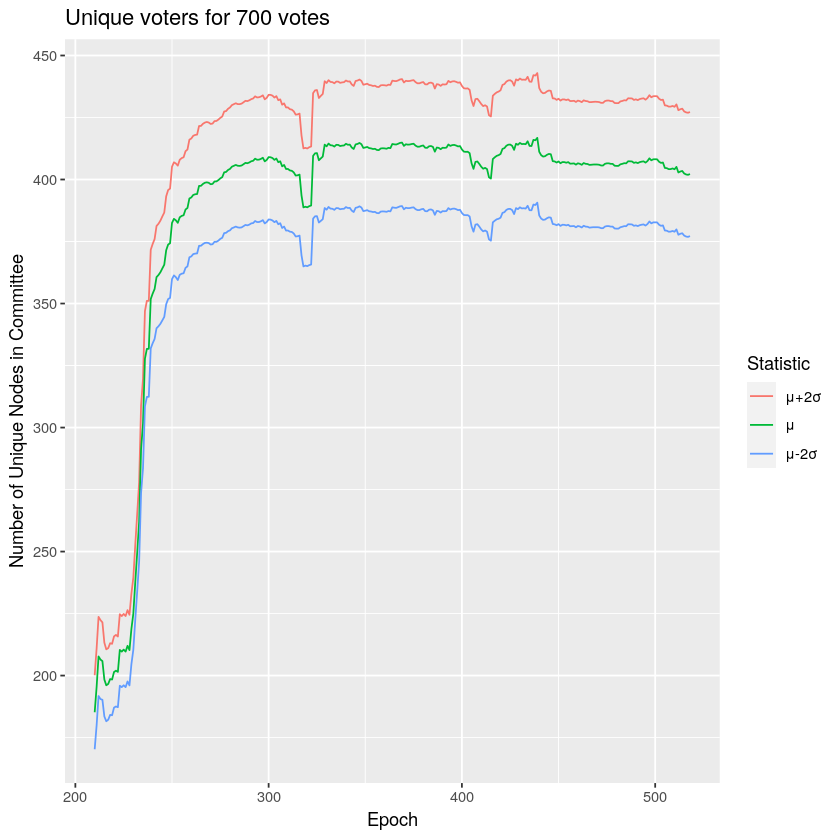

In [8]:
voteplot(700)

In [9]:
ggsave("committee_statistics-700.png", width=8, height=6, units="in", dpi=200)

In [10]:
ggsave("committee_statistics-700.svg", width=8, height=6, units="in", dpi=200)

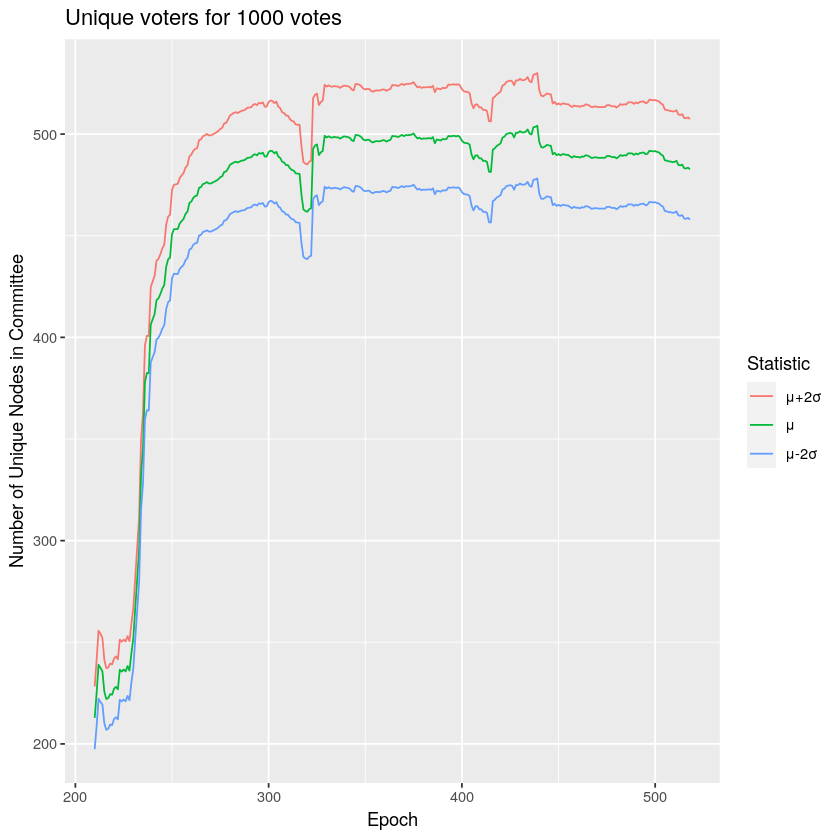

In [11]:
voteplot(1000)

In [12]:
ggsave("committee_statistics-1000.png", width=8, height=6, units="in", dpi=200)

In [13]:
ggsave("committee_statistics-1000.svg", width=8, height=6, units="in", dpi=200)

## Investigate the case of uniformly distributed stake

The worst-case scenario for number of unique nodes is when stake is uniformly distributed.

In [14]:
uniformStake <- 
    CJ(`Mean Number of Votes`=c(100,200,300,400,500,600,700,800,900,1000), `Number of Block Producers`=c(500,1000,1500,2000,2500,3000,3500,4000))[,
        committee(`Mean Number of Votes`, rep(stakeDistribution[`Epoch` == 500, sum(`Stake [Lovelace]`)] /  `Number of Block Producers`, `Number of Block Producers`)),
        by=.(`Mean Number of Votes`, `Number of Block Producers`)
    ]

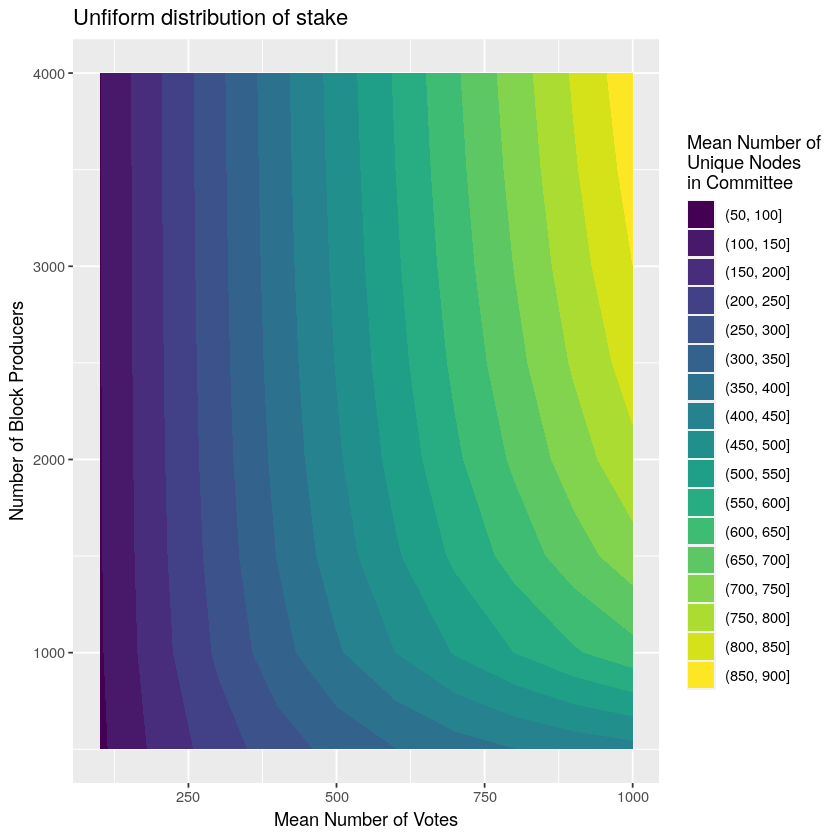

In [15]:
ggplot(uniformStake, aes(x=`Mean Number of Votes`, y=`Number of Block Producers`, z=`μ`)) +
  geom_contour_filled(binwidth=50) +
  guides(fill=guide_legend(title="Mean Number of\nUnique Nodes\nin Committee")) +
  ggtitle("Unfiform distribution of stake")

In [16]:
ggsave("uniform_statistics.png", width=8, height=6, units="in", dpi=200)

In [17]:
ggsave("uniform_statistics.svg", width=8, height=6, units="in", dpi=200)